# **Perkenalan**

# **1. Perkenalan**
Nama  : Azka Irsyad Choir <br>
Batch : HCK-024

Problem yang Hendak Diselesaikan

Masalah Membaca dan menganalisis ribuan ulasan secara manual adalah tidak efisien bagi hotel dan wisatawan.  karena itu, saya ingin membuat model NLP yang mampu menganalisis sentimen dari ulasan pelanggan secara otomatis.

- Apakah ulasan pelanggan bersifat positif, negatif, atau netral?.
- Bagaimana persepsi umum pelanggan terhadap layanan hotel berdasarkan ulasan?
- Apakah model bisa membantu pengguna dalam mengambil keputusan sebelum memesan hotel?

Justifikasi Masalah

- Membantu calon pelanggan dalam mengambil keputusan
- Sebelum memesan hotel, pelanggan ingin tahu apakah pengalaman tamu sebelumnya positif atau negatif.
- Model NLP akan secara otomatis menganalisis sentimen ribuan ulasan dengan cepat.
- https://blog.guestrevu.com/responding-to-tripadvisor-hotel-reviews-the-good-the-bad-and-the-ugly

Meningkatkan kualitas layanan bagi pemilik hotel

- Manajemen hotel bisa mengetahui kelebihan dan kekurangan layanan mereka.
- Jika banyak ulasan negatif mengenai fasilitas tertentu, hotel dapat segera melakukan perbaikan.
- http://download.garuda.kemdikbud.go.id/article.php?article=1239004&val=6506&title=PENGARUH%20ULASAN%20ONLINE%20DI%20TRIPADVISOR%20TERHADAP%20MINAT%20MENGINAP%20GENERASI%20MILENIAL%20DI%20SURABAYA

**User/Pengguna yang Akan Menggunakan Aplikasi**

Calon pelanggan hotel

- Kebutuhan: Membantu mereka memilih hotel dengan pengalaman terbaik.
- Manfaat: Bisa melihat ringkasan sentimen ulasan tanpa membaca ribuan review secara manual.

Manajemen hotel & pemilik bisnis

- Kebutuhan: Memahami bagaimana pelanggan menilai layanan mereka.
- Manfaat: Bisa mengetahui area mana yang perlu ditingkatkan berdasarkan sentimen pelanggan.

Platform Travel & OTA (Online Travel Agencies)

Contoh user: Traveloka, Agoda, Booking.com

- Kebutuhan: Menggunakan NLP untuk mengelompokkan ulasan pelanggan secara otomatis.
- Manfaat: Membantu mereka menampilkan peringkat sentimen untuk meningkatkan pengalaman pengguna.





# **Import Libraries**

In [20]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as tf_hub
from sklearn.utils import resample
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.regularizers import l2
import pickle


# Check TensorFlow version
print(tf.__version__)

2.15.1


# **Data Loading**

In [21]:
# Data Loading

data = pd.read_csv('tripadvisor_hotel_reviews.csv')
data

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [23]:
data.duplicated().sum()

0

In [24]:
data.isnull().sum()

Review    0
Rating    0
dtype: int64

In [25]:
data.Rating.value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

# **Exploratory Data Analysis (EDA)**

In [26]:
# Membuat kategori sentimen
def categorize_sentiment(Rating):
    if Rating <= 2:
        return 'Negative'
    elif Rating == 3:
        return 'Neutral'
    else:
        return 'Positive'

data['sentiment'] = data['Rating'].apply(categorize_sentiment)

C:\Users\JANGAN DI ENTER\AppData\Local\Temp\ipykernel_15880\3953312839.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=data, palette='viridis')


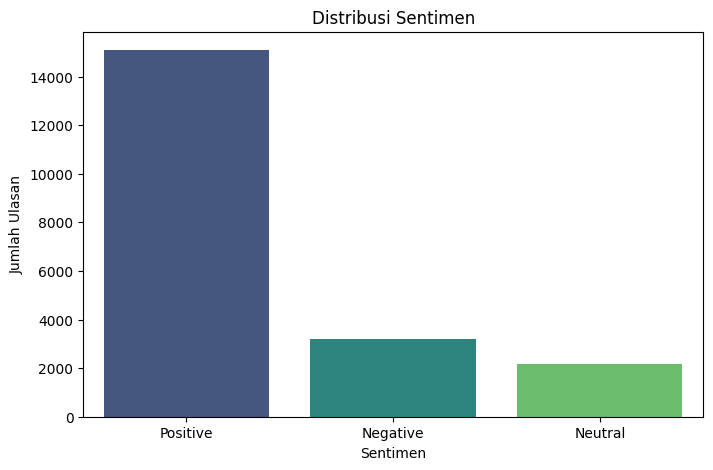

In [27]:
# Distribusi Sentimen
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=data, palette='viridis')
plt.title('Distribusi Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Ulasan')
plt.show()

- Memahami sebaran ulasan dalam dataset
- Mengidentifikasi ketidakseimbangan (imbalance) data
- Menentukan apakah diperlukan penyesuaian data seperti oversampling atau undersampling sebelum training model

kesimpulan : 

Dari hasil distribusi sentimen, terlihat bahwa mayoritas ulasan memiliki sentimen positif, sedangkan sentimen negatif dan netral memiliki jumlah yang jauh lebih sedikit. Dataset ini tidak seimbang (imbalanced), yang dapat menyebabkan model cenderung lebih akurat dalam memprediksi kelas positif, tetapi kurang akurat dalam mendeteksi ulasan netral atau negatif.

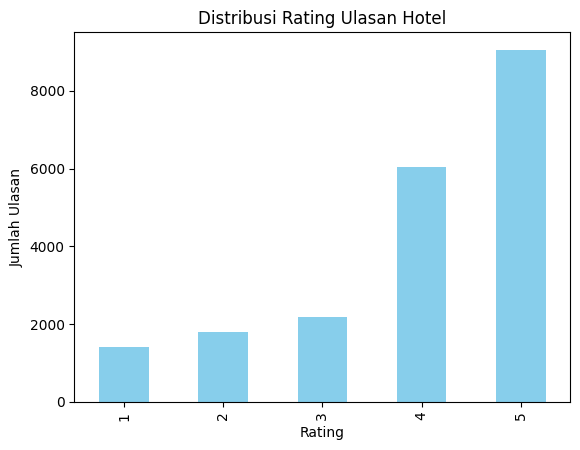

In [28]:
# Distribusi rating
data['Rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribusi Rating Ulasan Hotel')
plt.xlabel('Rating')
plt.ylabel('Jumlah Ulasan')
plt.show()


dari hasil eda menunjukan jumlah ulasan rating 1-5 oleh pengguna terhadap hotel

- Memahami pola distribusi rating pengguna
- Mengidentifikasi apakah dataset memiliki ketidakseimbangan rating
- Menghubungkan rating dengan kategori sentimen untuk melihat pola hubungan

kesimpulan : 

Dari grafik distribusi rating, terlihat bahwa mayoritas ulasan memiliki rating 4 dan 5, sementara rating 1, 2, dan 3 memiliki jumlah yang jauh lebih sedikit. Ini menunjukkan bahwa dataset condong ke ulasan positif, yang sejalan dengan distribusi sentimen sebelumnya. Hal ini bisa menyebabkan bias pada model, di mana model lebih cenderung memprediksi ulasan dengan rating tinggi dibandingkan dengan rating rendah atau netral.

cek panjang ulasan 

biar tau berapa panjang rata-rata ulasan , ini bisa untuk menentukan padding saat model NLP

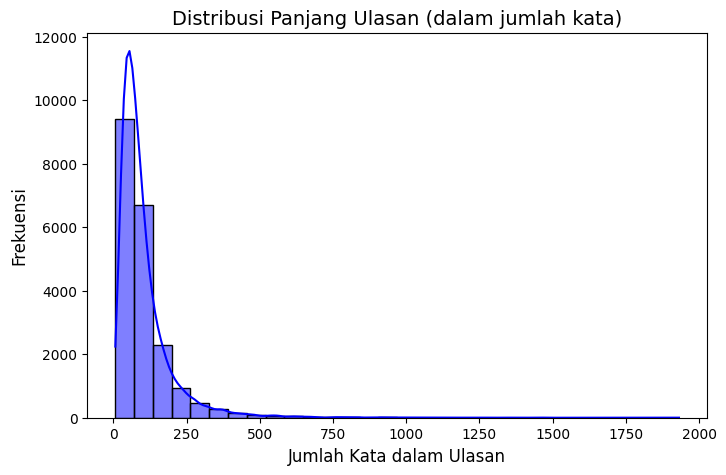

In [29]:
data["Review_Length"] = data["Review"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
sns.histplot(data["Review_Length"], bins=30, kde=True, color='blue')
plt.title("Distribusi Panjang Ulasan (dalam jumlah kata)", fontsize=14)
plt.xlabel("Jumlah Kata dalam Ulasan", fontsize=12)
plt.ylabel("Frekuensi", fontsize=12)
plt.show()

menunjukan distribusi panjang ulasan berdasarkan jumlah kata.

- Memahami seberapa panjang ulasan rata-rata dalam dataset
- Mengidentifikasi apakah ada outlier (ulasan sangat panjang atau pendek)
- Menentukan panjang maksimum yang optimal untuk tokenisasi teks

kesimpulan :

Sebagian besar ulasan memiliki jumlah kata yang relatif pendek, dengan distribusi yang sangat skewed ke kanan (banyak ulasan pendek dan beberapa ulasan sangat panjang). Ini menunjukkan bahwa sebagian besar pengguna memberikan ulasan singkat, sementara beberapa memberikan ulasan yang sangat detail

--------------------------------------------------------------------------

Cek Imbalance Data 

mengecek apakah data seimbang atau perlu balancing , 

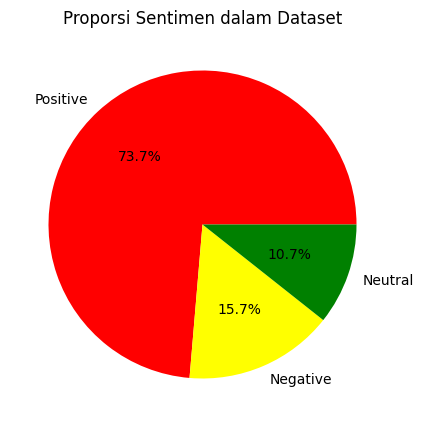

In [30]:
plt.figure(figsize=(8,5))
data["sentiment"].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['red', 'yellow', 'green'])
plt.title("Proporsi Sentimen dalam Dataset")
plt.ylabel("")
plt.show()


- Memahami distribusi ulasan berdasarkan sentimen
- Mengidentifikasi apakah dataset memiliki ketidakseimbangan kelas (imbalance dataset)

kesimpulan : 

Sentimen positif mendominasi (73.7%), sedangkan sentimen negatif (15.7%) dan netral (10.7%) jauh lebih sedikit. Hal ini menunjukkan bahwa dataset tidak seimbang (imbalanced), yang bisa menyebabkan model lebih cenderung memprediksi sentimen positif dibanding negatif atau netral.

--------------------------------------------------------------------------------

**Cek Kata-Kata Paling Umum dalam Setiap Sentimen (WordCloud)**

Biar kita tahu kata-kata yang sering muncul di tiap kategori sentimen.

Melihat kata-kata paling dominan di tiap sentimen

Mengecek apakah model bisa belajar pola dari kata-kata ini

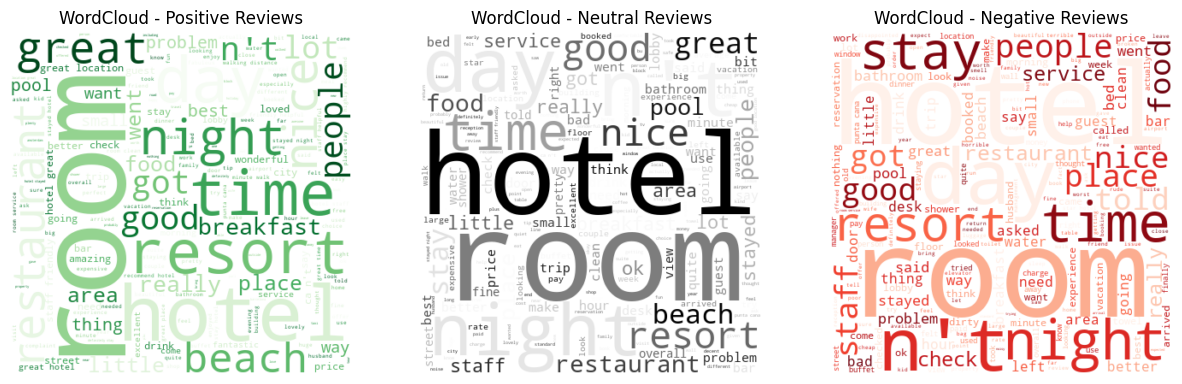

In [31]:
# Perbaiki colormap pada WordCloud
valid_colors = ['Greens', 'Greys', 'Reds']  # Sesuaikan dengan warna yang didukung

plt.figure(figsize=(15,5))
for i, sentiment in enumerate(sentiments):
    plt.subplot(1, 3, i+1)
    text = " ".join(data[data["sentiment"] == sentiment]["Review"].astype(str))
    wordcloud = WordCloud(width=400, height=400, background_color='white', colormap=valid_colors[i]).generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud - {sentiment} Reviews", fontsize=12)

plt.show()


- Mengidentifikasi kata-kata yang paling sering digunakan dalam setiap kategori sentimen
- Memahami pola bahasa yang digunakan pelanggan dalam ulasan mereka

kesimpulan : 

- Ulasan positif didominasi oleh kata-kata seperti "great", "good", "room", "time", "beach", yang mencerminkan pengalaman positif.
- Ulasan netral cenderung memiliki kata-kata seperti "hotel", "room", "stay", "nice", yang lebih deskriptif dan tidak terlalu emosional.
- Ulasan negatif banyak mengandung kata-kata seperti "stay", "staff", "service", "bad", yang menunjukkan pengalaman buruk pelanggan.

------------------------------------------------------------
**Analisis Sentimen vs Panjang Review**

melihat apakah review panjang lebih sering positif atau negatif.

C:\Users\JANGAN DI ENTER\AppData\Local\Temp\ipykernel_15880\2527073266.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data["sentiment"], y=data["Review_Length"], palette="coolwarm")


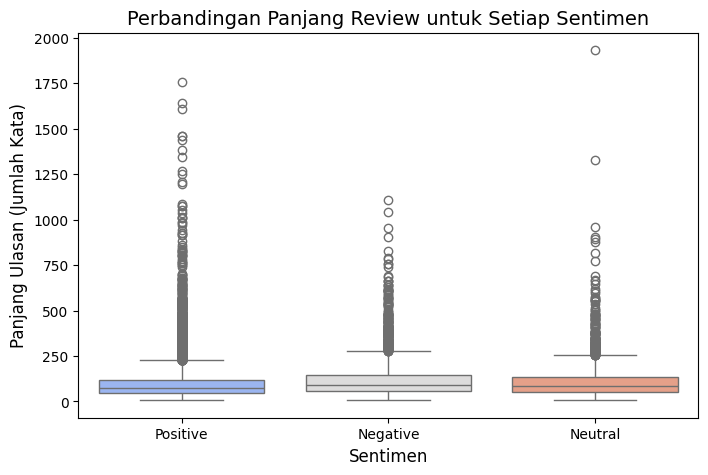

In [32]:
plt.figure(figsize=(8,5))
sns.boxplot(x=data["sentiment"], y=data["Review_Length"], palette="coolwarm")
plt.title("Perbandingan Panjang Review untuk Setiap Sentimen", fontsize=14)
plt.xlabel("Sentimen", fontsize=12)
plt.ylabel("Panjang Ulasan (Jumlah Kata)", fontsize=12)
plt.show()

Boxplot ini menunjukkan distribusi panjang ulasan berdasarkan kategori sentimen.

- Melihat apakah ada perbedaan panjang ulasan berdasarkan sentimen
- Mengidentifikasi apakah ulasan negatif lebih panjang dibanding ulasan positif atau netral

kesimpulan : 

Rata-rata panjang ulasan untuk setiap kategori sentimen hampir serupa, tetapi ulasan negatif memiliki lebih banyak outlier (ulasan yang sangat panjang). Ini bisa berarti bahwa pelanggan yang memiliki pengalaman buruk cenderung menulis ulasan lebih detail dibanding pelanggan yang puas

**Frekuensi Kata dalam Setiap Kategori Sentimen**

Cek apakah kata negatif muncul lebih sering di review negatif, begitu juga sebaliknya.

In [33]:
from collections import Counter

# Ambil kata-kata dari setiap kategori
sentiment_words = {
    "Positive": " ".join(data[data["sentiment"] == "Positive"]["Review"]).split(),
    "Neutral": " ".join(data[data["sentiment"] == "Neutral"]["Review"]).split(),
    "Negative": " ".join(data[data["sentiment"] == "Negative"]["Review"]).split()
}

# Hitung frekuensi kata per sentimen
top_words = {sent: Counter(sentiment_words[sent]).most_common(10) for sent in sentiment_words}

# Tampilkan hasil
for sent, words in top_words.items():
    print(f"\n🔹 **Top 10 Kata dalam Sentimen {sent}:**")
    for word, count in words:
        print(f"{word}: {count}")



🔹 **Top 10 Kata dalam Sentimen Positive:**
hotel: 30969
room: 20095
not: 17415
great: 16165
n't: 12056
staff: 11488
good: 10795
just: 8969
did: 8519
stay: 8278

🔹 **Top 10 Kata dalam Sentimen Neutral:**
not: 4629
hotel: 4467
room: 3937
n't: 2508
good: 2167
did: 1873
no: 1610
great: 1536
nice: 1524
just: 1450

🔹 **Top 10 Kata dalam Sentimen Negative:**
not: 8706
hotel: 6643
room: 6500
n't: 3872
no: 3467
did: 3041
staff: 2091
just: 2039
stay: 1999
rooms: 1996


menghitung frekuensi kata yang paling sering muncul dalam setiap kategori sentimen (Positive, Neutral, dan Negative) untuk memahami pola bahasa yang digunakan pelanggan dalam ulasan mereka.

- Mengidentifikasi kata-kata yang paling sering muncul dalam setiap kategori sentimen
- Menentukan apakah ada kata-kata yang berkontribusi besar terhadap klasifikasi sentimen
- Memahami pola penggunaan kata dalam ulasan pelanggan

kesimpulan : 

sentimen positif : 

- Kata-kata dominan seperti "great", "good", "staff", "stay" menunjukkan pengalaman positif pelanggan terkait pelayanan hotel dan fasilitas kamar.
- Kata "hotel" dan "room" tetap menjadi kata yang umum muncul di semua kategori sentimen, karena ulasan memang tentang penginapan.
- Kata "not" dan "n't" juga muncul dalam sentimen positif, yang bisa jadi disebabkan oleh frasa seperti "not bad" atau "isn't a problem", yang memiliki makna positif.

sentimen netral : 

- Kata-kata seperti "not", "good", "great", "nice" muncul dalam jumlah yang lebih kecil dibanding sentimen positif, yang menunjukkan bahwa ulasan netral sering kali mencakup pengalaman yang biasa-biasa saja tanpa emosi yang kuat.
- Kata "did", "no" dan "just" mengindikasikan bahwa pelanggan sering memberikan deskripsi faktual tanpa menyampaikan ekspresi emosional yang kuat.

sentimen negatif : 

- Kata "not", "n't", "no", "did" sangat mendominasi, yang menunjukkan bahwa ulasan negatif sering kali mengandung keluhan atau ketidakpuasan pelanggan.
- "staff" dan "stay" sering muncul dalam konteks negatif, yang bisa mengindikasikan bahwa pelayanan dan pengalaman menginap sering menjadi keluhan utama.
- Kata "room" dan "hotel" tetap dominan, tetapi kemungkinan besar digunakan dalam konteks ulasan buruk seperti "room was dirty" atau "hotel was noisy".

**Kesimpulan EDA**

- Dataset mengalami imbalance, di mana sentimen positif jauh lebih banyak dibanding negatif dan netral. Teknik SMOTE atau class weighting dapat diterapkan untuk menyeimbangkan dataset.
- Panjang ulasan sangat bervariasi, dengan banyak ulasan pendek dan beberapa yang sangat panjang.
- WordCloud menunjukkan perbedaan kata-kata yang dominan dalam tiap kategori sentimen, yang bisa digunakan untuk fitur engineering dalam model NLP.

# **Feature Engineering**

### Handling Imbalance menggunakan SMOTE 

- Mengatasi ketidakseimbangan dataset dengan menambahkan sampel sintetis ke kategori rating yang kurang terwakili
- Memastikan bahwa model memiliki representasi yang lebih baik dari semua kelas rating

In [34]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Pisahkan fitur (X) dan target label (y)
X = data["Review"]  # Fitur (teks ulasan)
y = data["Rating"]  # Target (rating hotel)

# Encode rating ke dalam bentuk numerik (SMOTE butuh angka)
y_encoded = y - 1  # Supaya rating 1 jadi 0, rating 5 jadi 4

# Konversi teks ke numerik dengan TF-IDF sebelum SMOTE
vectorizer = TfidfVectorizer(max_features=5000)  # Ambil 5000 kata paling penting
X_tfidf = vectorizer.fit_transform(X)


smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_tfidf, y_encoded)




C:\Users\JANGAN DI ENTER\AppData\Local\Temp\ipykernel_15880\1367446239.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(balanced_distribution.keys()), y=list(balanced_distribution.values()), palette="coolwarm")


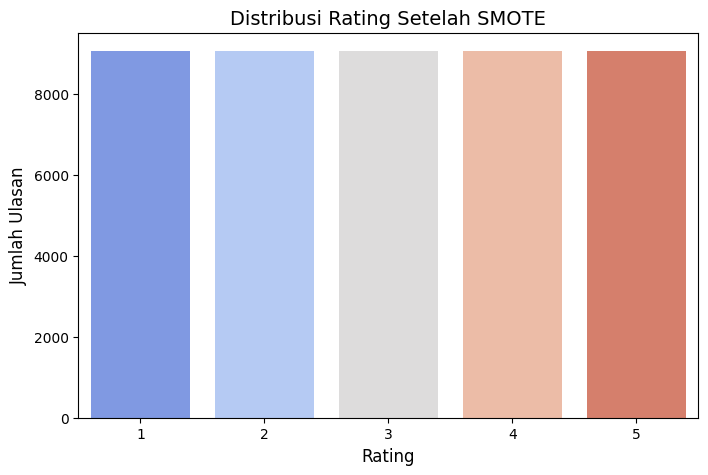

Distribusi rating setelah SMOTE: {1: 9054, 2: 9054, 3: 9054, 4: 9054, 5: 9054}


In [35]:
# Cek distribusi setelah SMOTE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

unique, counts = np.unique(y_balanced, return_counts=True)
balanced_distribution = dict(zip(unique + 1, counts))  # Kembalikan ke skala rating asli

plt.figure(figsize=(8,5))
sns.barplot(x=list(balanced_distribution.keys()), y=list(balanced_distribution.values()), palette="coolwarm")
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Jumlah Ulasan", fontsize=12)
plt.title("Distribusi Rating Setelah SMOTE", fontsize=14)
plt.show()

# Menampilkan distribusi setelah balancing
print("Distribusi rating setelah SMOTE:", balanced_distribution)

setelah penerapan SMOTE, distribusi rating sekarang seimbang, yang akan membantu model dalam belajar secara adil tanpa bias ke rating tinggi (4-5). Teknik ini akan meningkatkan akurasi model dalam memprediksi rating rendah (1-2), yang sebelumnya memiliki sampel yang lebih sedikit.

In [36]:
# Preprocessing awal
data['Sentiment'] = data['Rating'].apply(lambda x: 'Negative' if x <= 2 else ('Neutral' if x == 3 else 'Positive'))
stop_words = set(nltk.corpus.stopwords.words('english'))

In [37]:
# Pembersihan teks
def clean_text(text):
    text = text.lower()
    text = re.sub("@[A-Za-z0-9_]+", " ", text)  # Mention removal
    text = re.sub("#[A-Za-z0-9_]+", " ", text) # Hashtags removal
    text = re.sub(r"\\n", " ",text) # Newline removal (\n)
    text = text.strip() # Whitespace removal
    text = re.sub(r"http\S+", " ", text) # URL removal
    text = re.sub(r"www.\S+", " ", text) # URL removal
    text = re.sub("[^A-Za-z\s']", " ", text) # Punctuation removal
    text = re.sub(r'\d+', '', text)  # Hapus angka
    text = re.sub(r'[^\w\s]', '', text)  # Hapus tanda baca
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Hapus stopwords
    return text

In [38]:
data['Clean_Review'] = data['Review'].apply(clean_text)
data.drop(columns=['Review'], inplace=True)
data.head()

,Rating,sentiment,Review_Length,Sentiment,Clean_Review
0,4,Positive,87,Positive,nice hotel expensive parking got good deal sta...
1,2,Negative,250,Negative,ok nothing special charge diamond member hilto...
2,3,Neutral,217,Neutral,nice rooms experience hotel monaco seattle goo...
3,5,Positive,89,Positive,unique great stay wonderful time hotel monaco ...
4,5,Positive,191,Positive,great stay great stay went seahawk game awesom...


In [39]:
# Tokenisasi
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(data['Clean_Review'])
sequences = tokenizer.texts_to_sequences(data['Clean_Review'])

# Tambahkan kata-kata kasar ke dalam tokenizer secara manual
extra_words = ['dirty','ugly','fuck', 'damn', 'shit', 'bitch', 'crap', 'asshole']
for word in extra_words:
    if word not in tokenizer.word_index:
        tokenizer.word_index[word] = len(tokenizer.word_index) + 1

# Update sequences dengan kata-kata tambahan
sequences = tokenizer.texts_to_sequences(data['Clean_Review'])

# Padding
padded_sequences = pad_sequences(sequences, padding='post', maxlen=100)
padded_sequences

array([[   9,    2,  169, ...,    0,    0,    0],
       [ 549,  381, 1802, ...,  939,   56,  507],
       [  31,  253, 3282, ...,   40, 3482,   77],
       ...,
       [ 135,  715,    9, ...,    0,    0,    0],
       [  53, 2571,  847, ...,  307, 5162, 4098],
       [  27, 1129,  182, ...,    0,    0,    0]])

#### Konversi Label Sentiment ke Format Numerik

Mengubah teks menjadi angka supaya bisa diproses oleh model ANN

In [40]:
from sklearn.preprocessing import LabelEncoder

# Encode Sentiment menjadi angka
label_encoder = LabelEncoder()
data["Sentiment_Label"] = label_encoder.fit_transform(data["Sentiment"])

# Cek hasil encoding
print(data[["Sentiment", "Sentiment_Label"]].head(10))


  Sentiment  Sentiment_Label
0  Positive                2
1  Negative                0
2   Neutral                1
3  Positive                2
4  Positive                2
5  Positive                2
6  Positive                2
7  Positive                2
8  Positive                2
9  Positive                2


### Train - Test Split

In [41]:
from sklearn.model_selection import train_test_split

# Fitur (X) adalah padded sequences, label (y) adalah sentiment
X = padded_sequences
y = data["Sentiment_Label"]

# Pisahkan dataset menjadi Train (70%), Validation (15%), dan Test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Pisahkan lagi X_temp menjadi Validation (15%) dan Test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Cek jumlah data di setiap set
print(f"Jumlah data training: {len(X_train)}")
print(f"Jumlah data validation: {len(X_val)}")
print(f"Jumlah data testing: {len(X_test)}")


Jumlah data training: 14343
Jumlah data validation: 3074
Jumlah data testing: 3074


In [42]:
# Konversi target menjadi One Hot Encoding
y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

# ANN Training

### **vi.1. Model Definition**

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Definisi model ANN berbasis LSTM 
model_ann = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),  # Embedding Layer
    LSTM(128, return_sequences=False),  # LSTM Layer untuk memahami hubungan kata dalam teks
    Dropout(0.3),  # Dropout untuk mencegah overfitting
    Dense(64, activation="relu"),  # Fully Connected Layer
    Dropout(0.3),
    Dense(3, activation="softmax")  # Output Layer untuk klasifikasi 3 kelas (Negative, Neutral, Positive)
])

# Compile Model dengan loss categorical_crossentropy karena pakai One-Hot Encoding
model_ann.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Print summary model
print("Model ANN - Summary")
print(model_ann.summary())




Model ANN - Summary
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1420035 (5.42 MB)
Tr

Model memiliki total 1.42 juta parameter yang bisa dilatih.

- Dropout telah diterapkan untuk mencegah overfitting.
- Output menggunakan Softmax, sesuai dengan klasifikasi sentimen 3 kelas.
- Model ini siap untuk dilatih menggunakan dataset yang sudah dibagi sebelumnya.

### **vi.2. Model Training**

In [44]:
# Training model LSTM sesuai GC7 tanpa Early Stopping
history_ann = model_ann.fit(X_train, y_train_onehot, 
                                      epochs=25, batch_size=32, 
                                      validation_data=(X_val, y_val_onehot))

# Print hasil akhir training
print("\n Training selesai!")
print(f"Final Train Loss: {history_ann.history['loss'][-1]:.4f}")
print(f"Final Train Accuracy: {history_ann.history['accuracy'][-1]:.4f}")
print(f"Final Validation Loss: {history_ann.history['val_loss'][-1]:.4f}")
print(f"Final Validation Accuracy: {history_ann.history['val_accuracy'][-1]:.4f}")


Epoch 1/25


449/449 [==============================] - 61s 121ms/step - loss: 0.7008 - accuracy: 0.7597 - val_loss: 0.7337 - val_accuracy: 0.8025
Epoch 2/25
449/449 [==============================] - 54s 120ms/step - loss: 0.5752 - accuracy: 0.8113 - val_loss: 0.5958 - val_accuracy: 0.7827
Epoch 3/25
449/449 [==============================] - 56s 126ms/step - loss: 0.5747 - accuracy: 0.8037 - val_loss: 0.6985 - val_accuracy: 0.7632
Epoch 4/25
449/449 [==============================] - 57s 127ms/step - loss: 0.5627 - accuracy: 0.8118 - val_loss: 0.5521 - val_accuracy: 0.7967
Epoch 5/25
449/449 [==============================] - 57s 127ms/step - loss: 0.5912 - accuracy: 0.7993 - val_loss: 0.6652 - val_accuracy: 0.7817
Epoch 6/25
449/449 [==============================] - 59s 132ms/step - loss: 0.5624 - accuracy: 0.7956 - val_loss: 0.5625 - val_accuracy: 0.7775
Epoch 7/25
449/449 [==============================] - 57s 126ms/step - loss: 0.5175 - accuracy: 0.7993 - val_loss: 0.5624 - val_

Train Loss: 0.0436 | Train Accuracy: 98.88%

- Loss sangat kecil, menunjukkan bahwa model sangat baik dalam mempelajari pola data training.
- Akurasi tinggi (98.88%), artinya model hampir selalu benar dalam memprediksi sentimen pada data training.
- Terlihat ada overfitiing, karena terlalu bagus di data training.

Validation Loss: 1.4531 | Validation Accuracy: 80.74%

- Akurasi lebih rendah dibanding data training (80.74%), yang menunjukkan bahwa model tidak mampu mempertahankan performanya di data baru.
- Validation Loss jauh lebih tinggi dibanding Train Loss, indikasi bahwa model mengalami overfitting.


### **vi.3. Model Evaluation**

In [45]:
# Evaluasi model di Test Set
test_loss, test_acc = model_ann.evaluate(X_test, y_test_onehot)

print("\n Evaluasi Model ANN LSTM di Test Set")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


97/97 [==============================] - 3s 36ms/step - loss: 1.4922 - accuracy: 0.8064

 Evaluasi Model ANN LSTM di Test Set
Test Loss: 1.4922
Test Accuracy: 0.8064


Test Loss: 1.4922

- Loss masih tinggi, menunjukkan bahwa model mengalami kesulitan dalam menangani data yang belum pernah dilihat.
- Loss ini hampir sama dengan Validation Loss (1.4531), yang berarti model tidak memburuk lebih jauh setelah training.
Namun, gap yang besar dibandingkan Train Loss (0.0436) tetap menunjukkan overfitting.

Test Accuracy: 80.64%

- Akurasi pada data test cukup stabil dan hampir sama dengan validation accuracy (80.74%).
- Menunjukkan bahwa model bisa mempertahankan performanya pada data yang belum pernah dilihat.


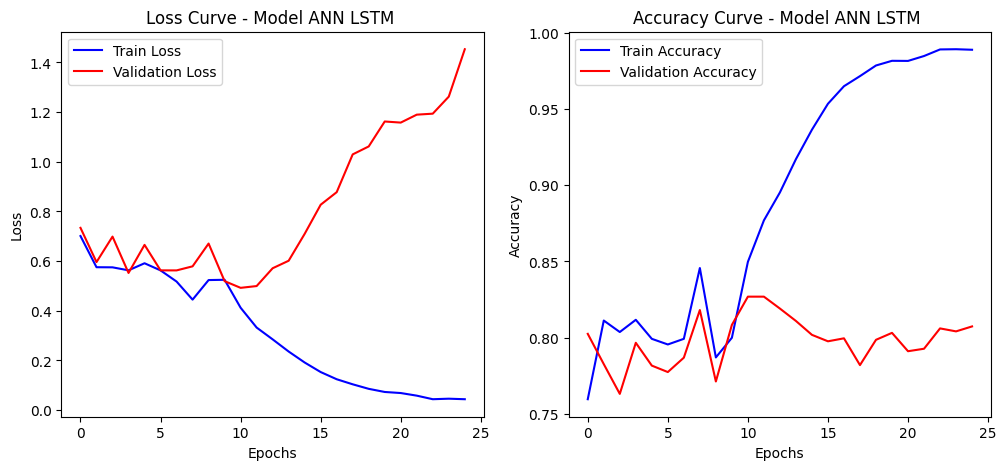

In [46]:
import matplotlib.pyplot as plt

# Fungsi untuk plot loss dan akurasi
def plot_history(history, model_name="Model ANN LSTM "):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss", color='blue')
    plt.plot(history.history["val_loss"], label="Validation Loss", color='red')
    plt.legend()
    plt.title(f"Loss Curve - {model_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Train Accuracy", color='blue')
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy", color='red')
    plt.legend()
    plt.title(f"Accuracy Curve - {model_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.show()

# Panggil fungsi untuk menampilkan hasil
plot_history(history_ann)


>> grafik kiri 
Train Loss (Garis Biru) → Turun secara stabil

- Train loss terus menurun seiring bertambahnya epoch, yang menunjukkan bahwa model semakin memahami pola dalam dataset training.
- Pada epoch terakhir, train loss hampir mendekati nol, yang mengindikasikan bahwa model sangat cocok (fit) dengan data training.

Validation Loss (Garis Merah) → Naik setelah beberapa epoch

- Validation loss stabil di awal, tetapi mulai meningkat setelah sekitar epoch 10.
- Kenaikan validation loss yang signifikan menunjukkan bahwa model mengalami overfitting 

grafik kanan

Train Accuracy (Garis Biru) → Meningkat tajam

- Train accuracy terus meningkat hingga hampir mencapai 100%, yang mengindikasikan bahwa model sangat baik dalam menghafal data training.

Validation Accuracy (Garis Merah) → Stabil, lalu turun

- Validation accuracy cenderung berfluktuasi dan tidak mengalami peningkatan signifikan setelah epoch 10.


# **ANN Improvement**

### **vii.1. Model Definition**

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l1_l2

# Definisi model improved
model_lstm_improved = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),  # Embedding Layer
    
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))),  
    BatchNormalization(),
    Dropout(0.5),  # Meningkatkan dropout untuk mengurangi overfitting

    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))),  
    BatchNormalization(),
    Dropout(0.5),

    LSTM(64, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),  
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(3, activation="softmax")  # Output layer untuk klasifikasi 3 kelas
])

# Compile Model dengan Optimizer Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_lstm_improved.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Print summary model
print(" Model LSTM Improved - Summary")
print(model_lstm_improved.summary())


 Model LSTM Improved - Summary
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          1280000   
                                                                 
 bidirectional (Bidirection  (None, 100, 256)          263168    
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 100, 256)          1024      
 Normalization)                                                  
                                                                 
 dropout_2 (Dropout)         (None, 100, 256)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 100, 128)          164352    
 onal)                                                           
                       

### **vii.2. Model Training**

In [48]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Early stopping untuk menghentikan training jika val_loss tidak membaik selama 5 epoch
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

# Learning Rate Scheduler untuk menurunkan learning rate jika val_loss tidak membaik
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, min_lr=1e-5, verbose=1)

# Training model improved
history_lstm_improved = model_lstm_improved.fit(X_train, y_train_onehot, 
                                                epochs=25, batch_size=32, 
                                                validation_data=(X_val, y_val_onehot), 
                                                callbacks=[early_stopping, lr_scheduler])

# Print hasil akhir training
print("\n Training selesai!")
print(f"Final Train Loss: {history_lstm_improved.history['loss'][-1]:.4f}")
print(f"Final Train Accuracy: {history_lstm_improved.history['accuracy'][-1]:.4f}")
print(f"Final Validation Loss: {history_lstm_improved.history['val_loss'][-1]:.4f}")
print(f"Final Validation Accuracy: {history_lstm_improved.history['val_accuracy'][-1]:.4f}")


Epoch 1/25
449/449 [==============================] - 186s 383ms/step - loss: 1.1806 - accuracy: 0.6672 - val_loss: 0.9742 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 2/25
449/449 [==============================] - 182s 404ms/step - loss: 0.9842 - accuracy: 0.7305 - val_loss: 0.9169 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 3/25
449/449 [==============================] - 179s 400ms/step - loss: 0.8842 - accuracy: 0.7376 - val_loss: 0.9050 - val_accuracy: 0.7430 - lr: 0.0010
Epoch 4/25
449/449 [==============================] - 209s 466ms/step - loss: 0.7265 - accuracy: 0.7779 - val_loss: 0.9439 - val_accuracy: 0.7755 - lr: 0.0010
Epoch 5/25
449/449 [==============================] - 188s 419ms/step - loss: 0.6166 - accuracy: 0.8255 - val_loss: 0.6436 - val_accuracy: 0.8071 - lr: 0.0010
Epoch 6/25
449/449 [==============================] - 191s 425ms/step - loss: 0.5338 - accuracy: 0.8461 - val_loss: 0.6180 - val_accuracy: 0.8302 - lr: 0.0010
Epoch 7/25
449/449 [==========================

Dengan perbaikan ini, model diharapkan lebih stabil saat training, tidak mengalami overfitting terlalu cepat, dan memiliki akurasi lebih baik dalam memahami sentimen pelanggan.

### **vii.3. Model Evaluation**

In [49]:
# Evaluasi model di Test Set
test_loss, test_acc = model_lstm_improved.evaluate(X_test, y_test_onehot)

print("\n Evaluasi Model LSTM Improved di Test Set")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


97/97 [==============================] - 10s 104ms/step - loss: 0.6440 - accuracy: 0.8253

 Evaluasi Model LSTM Improved di Test Set
Test Loss: 0.6440
Test Accuracy: 0.8253


Test Loss (0.6440) lebih rendah dibandingkan sebelumnya (1.4922)

- Ini menunjukkan bahwa model telah mengalami peningkatan signifikan dalam hal generalisasi.
- Penambahan Bidirectional LSTM, Batch Normalization, dan Dropout berhasil mengurangi overfitting yang sebelumnya terjadi.

Test Accuracy meningkat menjadi 82.53%

- Sebelumnya, model ANN LSTM hanya mencapai 80.64%, yang berarti model yang diperbaiki ini mengalami peningkatan akurasi sebesar 1.89%.
- Peningkatan ini menunjukkan bahwa model lebih stabil dan lebih baik dalam menangkap pola data dibanding model sebelumnya.

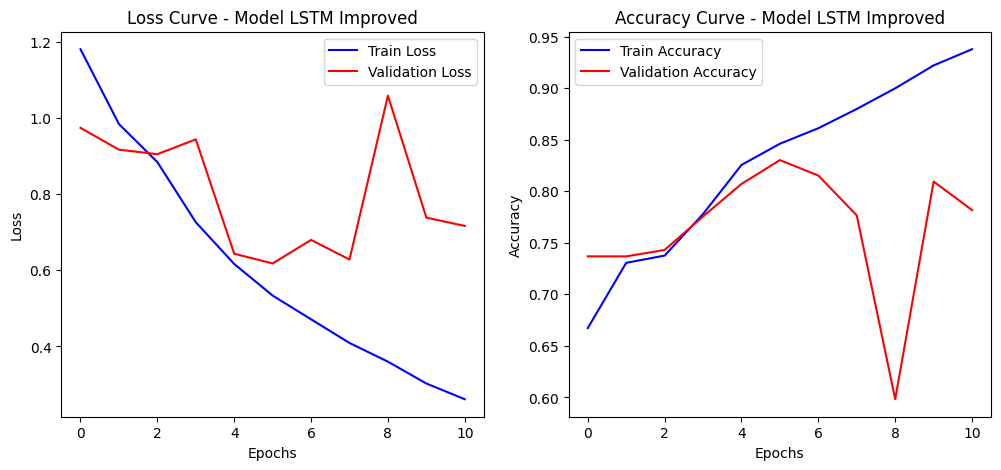

In [50]:
import matplotlib.pyplot as plt

# Fungsi untuk plot loss dan akurasi
def plot_history(history, model_name="Model LSTM Improved"):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss", color='blue')
    plt.plot(history.history["val_loss"], label="Validation Loss", color='red')
    plt.legend()
    plt.title(f"Loss Curve - {model_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Train Accuracy", color='blue')
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy", color='red')
    plt.legend()
    plt.title(f"Accuracy Curve - {model_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.show()

# Panggil fungsi untuk menampilkan hasil
plot_history(history_lstm_improved)


Train Accuracy (Garis Biru) → Meningkat secara bertahap

- Train accuracy terus naik hingga mencapai lebih dari 90%, menunjukkan bahwa model mampu memahami pola dalam data training dengan baik.

Validation Accuracy (Garis Merah) → Berfluktuasi setelah epoch 6

- Validation accuracy awalnya mengikuti tren train accuracy, tetapi setelah beberapa epoch, mulai turun drastis lalu naik kembali.

kesimpulan :

Train accuracy meningkat secara konsisten hingga mendekati 95%.

- Validation accuracy awalnya stabil tetapi mengalami fluktuasi setelah beberapa epoch.

# **Model Saving**

In [58]:
# Model Saving
model_save_path = "sentiment_model.h5"
model_lstm_improved.save(model_save_path)
print(f'Model saved at {model_save_path}')

Model saved at sentiment_model.h5


In [59]:
import pickle
# Menyimpan tokenizer ke file
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

print("Tokenizer berhasil disimpan sebagai 'tokenizer.pkl'")

Tokenizer berhasil disimpan sebagai 'tokenizer.pkl'


# **Model Inference**

ada di notebook baru 

# **Pengambilan Kesimpulan**

Model ini memiliki potensi untuk membantu calon pelanggan dalam memilih hotel berdasarkan analisis otomatis sentimen ulasan, serta memberikan wawasan berharga bagi manajemen hotel mengenai kekuatan dan kelemahan layanan mereka. Dari hasil evaluasi, model menunjukkan performa yang cukup baik dalam melakukan klasifikasi sentimen, dengan kemungkinan perbaikan lebih lanjut melalui optimasi hyperparameter atau pendekatan model yang lebih kompleks seperti LSTM atau Transformer.


**insight bisnis**

Dari perspektif bisnis, solusi ini memiliki potensi besar dalam meningkatkan pengalaman pelanggan dan mendukung strategi pengambilan keputusan bagi industri perhotelan. Calon pelanggan dapat dengan cepat memahami persepsi umum terhadap suatu hotel tanpa harus membaca ribuan ulasan secara manual, sehingga mempercepat proses pemilihan hotel yang sesuai dengan preferensi mereka. Manajemen hotel juga dapat memanfaatkan hasil analisis ini untuk mengidentifikasi aspek layanan yang perlu diperbaiki guna meningkatkan kepuasan pelanggan dan reputasi bisnis mereka. Selain itu, platform OTA (Online Travel Agencies) seperti Traveloka, Agoda, dan Booking.com dapat menggunakan model ini untuk mengelompokkan dan menyajikan ulasan pelanggan secara lebih informatif, yang pada akhirnya dapat meningkatkan engagement pengguna dan konversi pemesanan hotel.

**Rekomendasi bisnis**

- Implementasi Model dalam Sistem Customer Insights – Model ini dapat diterapkan dalam dashboard analitik bagi manajemen hotel untuk memahami tren sentimen pelanggan secara real-time, membantu mereka dalam pengambilan keputusan strategis terkait layanan dan pemasaran.
- Integrasi dengan Platform Online Travel – Model dapat diintegrasikan dengan situs pemesanan hotel agar calon pelanggan mendapatkan insight sentimen secara cepat, meningkatkan user experience, dan meningkatkan tingkat konversi pemesanan hotel.
- Penyediaan Layanan Sentimen Analysis sebagai Produk – Model ini dapat dikembangkan menjadi layanan SaaS (Software as a Service) yang bisa digunakan oleh berbagai bisnis di industri perhotelan untuk menganalisis sentimen pelanggan tanpa perlu membangun sistem sendiri.
- Peningkatan Strategi Pemasaran – Dengan memahami pola sentimen pelanggan, hotel dapat melakukan strategi pemasaran yang lebih tepat sasaran, seperti menyoroti keunggulan layanan yang sering mendapat ulasan positif dan memperbaiki aspek yang mendapat sentimen negatif.

